# Part One: Abstract Class

New Class named GassDistribution: Inherits from ContinousDistribution.
In this implementation, GaussDistribution inherits from ContinuousDistribution and provides concrete implementations for all its abstract methods. The constructor takes an optional dim parameter, which sets the dimension of the multivariate distribution (default value is 1).

The import_data and export_data methods are left unimplemented in this example, as they are not specific to the Gaussian distribution and can be implemented differently for different types of distributions.

The compute_mean method calculates the mean of the data and updates the mean attribute of the Gaussian distribution. Similarly, the compute_standard_deviation method calculates the covariance matrix of the data and updates the covariance attribute of the Gaussian distribution.

The visualize method generates a random sample of data from the Gaussian distribution using the multivariate_normal.rvs function from the scipy.stats module. If the data parameter is not provided, it uses this random sample to visualize the distribution. Otherwise, it visualizes the provided data.

The generate_samples method generates a given number of random samples from the Gaussian distribution using the multivariate_normal.rvs function and returns them.

In [133]:
import abc

class ContinuousDistribution(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def import_data(self, file_path):
        pass
    
    @abc.abstractmethod
    def export_data(self, data, file_path):
        pass
    
    @abc.abstractmethod
    def compute_mean(self, data):
        pass
    
    @abc.abstractmethod
    def compute_standard_deviation(self, data):
        pass
    
    @abc.abstractmethod
    def visualize(self, data=None):
        pass
    
    @abc.abstractmethod
    def generate_samples(self, n_samples):
        pass

# Part Two: Inherit class GaussianDistribution

In [134]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
import pandas as pd


class GaussDistribution(ContinuousDistribution):
    def __init__(self, dim=1):
        self.dim = dim
        self.mean = np.zeros(dim)
        self.covariance = np.eye(dim)
        self.data = pd.DataFrame()
        self.samples = None
    
    def import_data(self, file_path):
        # implementation to import data from file
        self.data = pd.read_csv(file_path)
    
    def export_data(self, data, file_path):
        # implementation to export data to file
        df = pd.DataFrame(data)
        df.to_csv(file_path)
    
    def compute_mean(self, data):
        self.mean = np.mean(data, axis=0)
    
    def compute_standard_deviation(self, data):
        self.covariance = np.cov(data, rowvar=False)
    
    def visualize(self, data=None):
        if data is None:
            data = multivariate_normal.rvs(mean=self.mean, cov=self.covariance, size=1000)
        
        if self.dim == 1:
            mean = 0
            covariance = 0.8
            x = np.linspace(mean - 3*np.sqrt(covariance), mean + 3*np.sqrt(covariance), 100)
            plt.plot(x, multivariate_normal.pdf(x, mean=mean, cov=covariance), color = 'blue')
            plt.title(f'1D Gaussian Distribution with a mean of {mean} and a covariance of {covariance}')
            
            plt.savefig('gaussian1D.pdf', bbox_inches='tight', transparent=True)
            plt.show()
            
        elif self.dim == 2:
            covariance = np.array([[1, 0.8],
                                     [0.8, 1]])
            mean = np.array([0, 0])
            x, y = np.mgrid[mean[0]-3*np.sqrt(covariance[0,0]):mean[0]+3*np.sqrt(covariance[0,0]):.01,
                            mean[1]-3*np.sqrt(covariance[1,1]):mean[1]+3*np.sqrt(covariance[1,1]):.01]
            pos = np.empty(x.shape + (2,))
            pos[:, :, 0] = x
            pos[:, :, 1] = y
            rv = multivariate_normal(mean, covariance)

            # Generating the density function
            # for each point in the meshgrid
            pdf = np.zeros(x.shape)
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    pdf[i,j] = rv.pdf([x[i,j], y[i,j]])
            
            pdf_list = []
            fig = plt.figure()

            # Plotting the density function values
            bx = fig.add_subplot(131, projection = '3d')
            bx.plot_surface(x, y, pdf, cmap = 'viridis')
            plt.xlabel("x1")
            plt.ylabel("x2")
            plt.title(f'2D Gaussian Distribution with a mean of {mean} and a covariance of {covariance}')
            pdf_list.append(pdf)
            bx.axes.zaxis.set_ticks([])
            
            plt.tight_layout()
            
            plt.savefig('gaussian2D_surface.pdf', bbox_inches='tight', transparent=True)
            plt.show()

            # Plotting contour plots
            for idx, val in enumerate(pdf_list):
                plt.subplot(1,3,idx+1)
                plt.contourf(x, y, val, cmap='viridis')
                plt.xlabel("x1")
                plt.ylabel("x2")
            plt.tight_layout()
            plt.title(f'2D Gaussian Distribution Contour with a mean of {mean} and a covariance of {covariance}')
            
            plt.savefig('gaussian2D_contour.pdf', bbox_inches='tight', transparent=True)
            plt.show()
            
        elif self.dim == 3:
            fig = plt.figure(figsize=(10, 5))
            ax1 = fig.add_subplot(1, 2, 1, projection='3d')
            x, y, z = np.mgrid[self.mean[0]-3*np.sqrt(self.covariance[0,0]):self.mean[0]+3*np.sqrt(self.covariance[0,0]):.1,
                               self.mean[1]-3*np.sqrt(self.covariance[1,1]):self.mean[1]+3*np.sqrt(self.covariance[1,1]):.1,
                               self.mean[2]-3*np.sqrt(self.covariance[2,2]):self.mean[2]+3*np.sqrt(self.covariance[2,2]):.1]
            
            # Plot the samples from the file
            ax1.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], c='blue', alpha=0.5)
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')
            ax1.set_zlabel('z')
            ax1.set_title('Data from File')

            ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            ax2.scatter(self.samples[:, 0], self.samples[:, 1], self.samples[:, 2], c='orange', alpha=0.5)
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.set_zlabel('z')
            ax2.set_title('Data from Samples')

            plt.savefig('gaussian3D.pdf', bbox_inches='tight', transparent=True)
            plt.show()
            
    def generate_samples(self, n_samples):
        self.samples = multivariate_normal.rvs(mean=self.mean, cov=self.covariance, size=n_samples)

In [135]:
gd = GaussDistribution(dim=3)

In [136]:
gd.import_data('MGD.csv')
data = gd.data
print(data.iloc[:,0])

0     1.837130
1     1.847345
2    -0.769538
3     0.027689
4     2.195373
        ...   
95    1.552589
96    1.600879
97    3.044786
98    1.463682
99   -0.877454
Name: x, Length: 100, dtype: float64


In [137]:
gd.export_data(data, 'out.csv')

In [138]:
gd.compute_mean(data)
print(gd.mean)

x    0.984026
y    0.008833
z    0.860115
dtype: float64


In [139]:
gd.compute_standard_deviation(data)
print(gd.covariance)

[[0.95707677 0.65248406 0.5632227 ]
 [0.65248406 1.42016015 0.75382979]
 [0.5632227  0.75382979 1.25559884]]


In [140]:
gd.generate_samples(100)
print(type(gd.samples))

<class 'numpy.ndarray'>


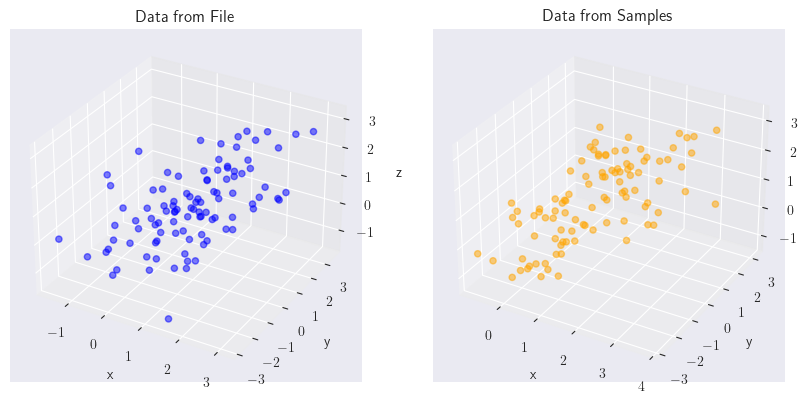

           x         y         z
0   1.837130  2.830783  2.489846
1   1.847345  0.540222  0.105313
2  -0.769538 -0.960047 -0.548962
3   0.027689 -0.138528 -0.095424
4   2.195373 -0.348212  1.115202
..       ...       ...       ...
95  1.552589 -2.819266 -1.448327
96  1.600879  1.133391  1.018098
97  3.044786  0.552303  1.601142
98  1.463682  0.533689  2.428866
99 -0.877454 -0.831181  1.295999

[100 rows x 3 columns]


In [141]:
gd.visualize(gd.data)
print(gd.data)

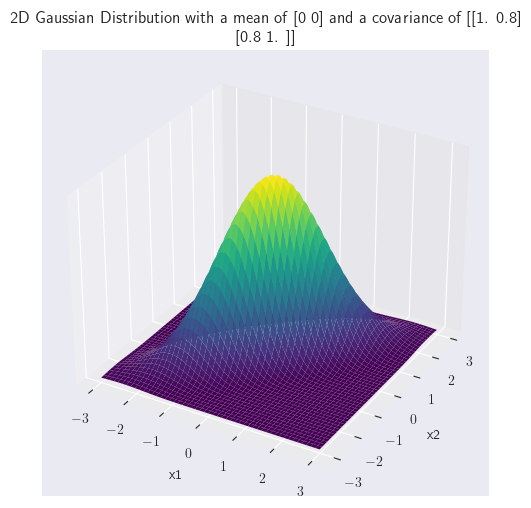

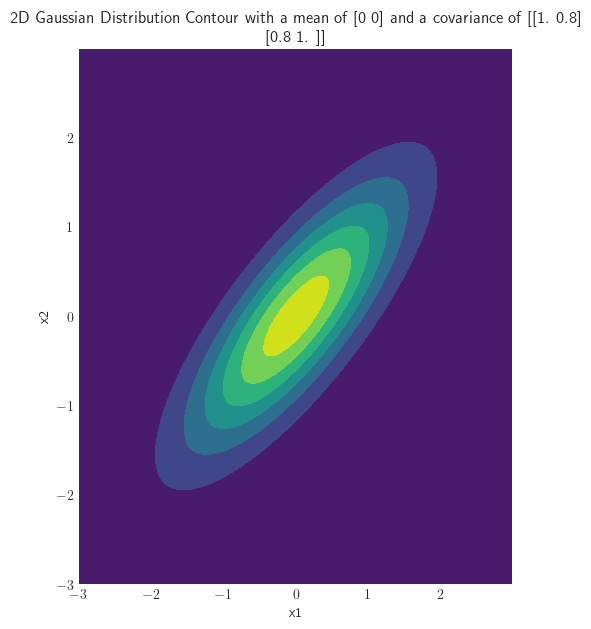

In [142]:
gd2 = GaussDistribution(dim=2)
gd2.visualize()


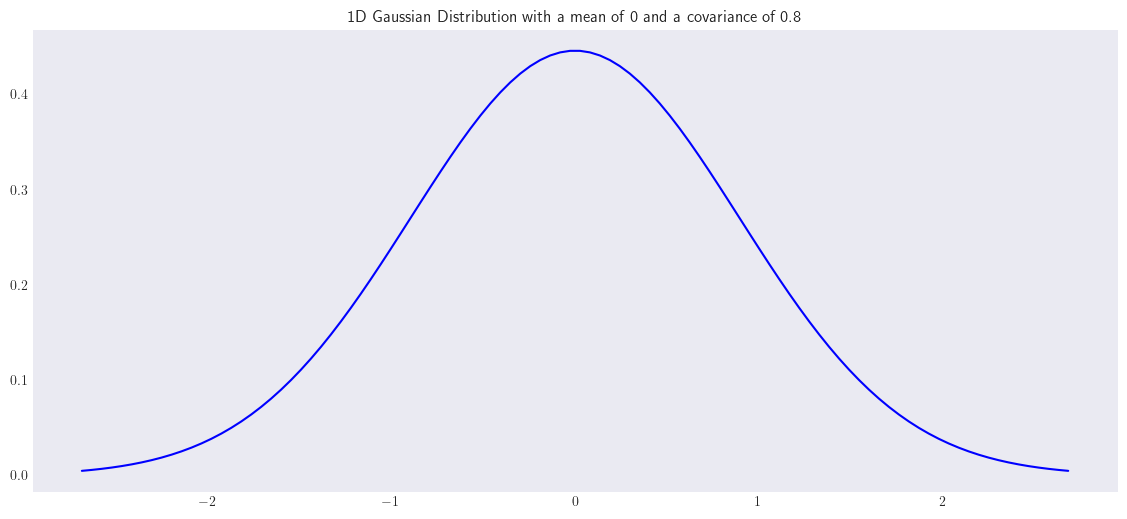

In [143]:
gd1 = GaussDistribution(dim=1)
gd1.visualize()

# Part Three: Beta Distribution

In [145]:
from scipy.stats import beta

class BetaDistribution(ContinuousDistribution):
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.data = None

    def import_data(self, file_path):
        # implement import data method for BetaDistribution
        self.data = pd.read_csv(file_path)

    def export_data(self, data, file_path):
        # implement export data method for BetaDistribution
        pass

    def compute_mean(self, data):
        # implement compute mean method for BetaDistribution
        pass

    def compute_standard_deviation(self, data):
        # implement compute standard deviation method for BetaDistribution
        pass

    def visualize(self, data=None):
        # create a range of x values
        x = np.linspace(0, 1, 100)

        # calculate the beta PDF for the given parameters a and b
        y = beta.pdf(x, self.a, self.b)

        # plot the beta PDF
        plt.plot(x, y, label='Beta PDF')

        # plot the mean and standard deviation lines
        mean = beta.mean(self.a, self.b)
        std = beta.std(self.a, self.b)
        plt.axvline(mean, color='red', label=f'Mean={mean:.2f}')
        plt.axvline(mean - std, linestyle='--', color='green', label=f'Std Dev={std:.2f}')
        plt.axvline(mean + std, linestyle='--', color='green')

        # set the plot title and legend
        plt.title(f'Beta Distribution (a={self.a}, b={self.b})')
        plt.legend()

        # show the plot
        plt.savefig('beta.pdf', bbox_inches='tight', transparent=True)
        
        plt.show()
    
    def visualize_book(self, data=None):
        # create a range of x values
        x = np.linspace(0, 1, 100)

        # calculate the beta PDF for the given parameters a and b
        y1 = beta.pdf(x, 0.5, 0.5)
        y2 = beta.pdf(x, 2, 5)
        y3 = beta.pdf(x, 5, 2)

        # plot the beta PDF
        plt.plot(x, y1, label='a=b=0.5')
        plt.plot(x, y2, label='a=2, b=5')
        plt.plot(x, y3, label='a=5, b=2')

        # plot the mean and standard deviation lines
        # mean = beta.mean(self.a, self.b)
        # std = beta.std(self.a, self.b)
        # plt.axvline(mean, color='red', label=f'Mean={mean:.2f}')
        # plt.axvline(mean - std, linestyle='--', color='green', label=f'Std Dev={std:.2f}')
        # plt.axvline(mean + std, linestyle='--', color='green')

        # fig = plt.figure(figsize=(10, 5))
        # ax1 = fig.add_subplot(1, 2, 1)
        # ax2 = fig.add_subplot(1, 2, 2)
        # ax3 = fig.add_subplot(1, 2, 2)

        # ax1.plot(x, y1, c='blue', alpha=0.5)
        # ax1.set_xlabel('x')
        # ax1.set_ylabel('y')
        # ax1.set_zlabel('z')
        # ax1.set_title('Data from File')
        
        # set the plot title and legend
        plt.title(f'Beta Distribution')
        plt.legend()

        # show the plot
        plt.savefig('beta.pdf' , bbox_inches='tight', transparent=True)
        plt.show()

    def generate_samples(self, n_samples):
        # generate beta distributed samples using the given parameters a and b
        return beta.rvs(self.a, self.b, size=n_samples)

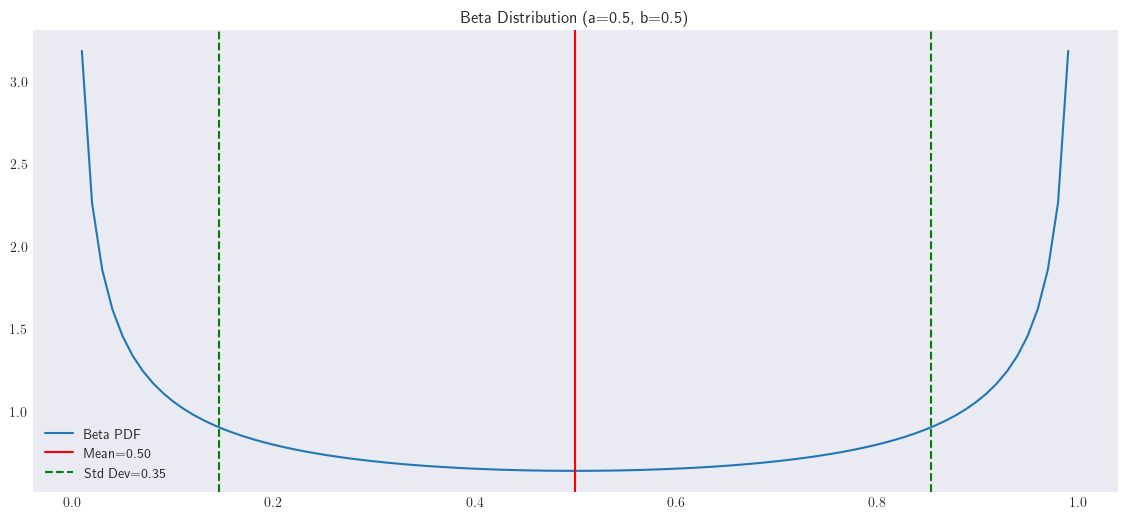

In [146]:
bt = BetaDistribution(0.5,0.5)
bt.import_data('MGD.csv')
bt.visualize(bt.data)

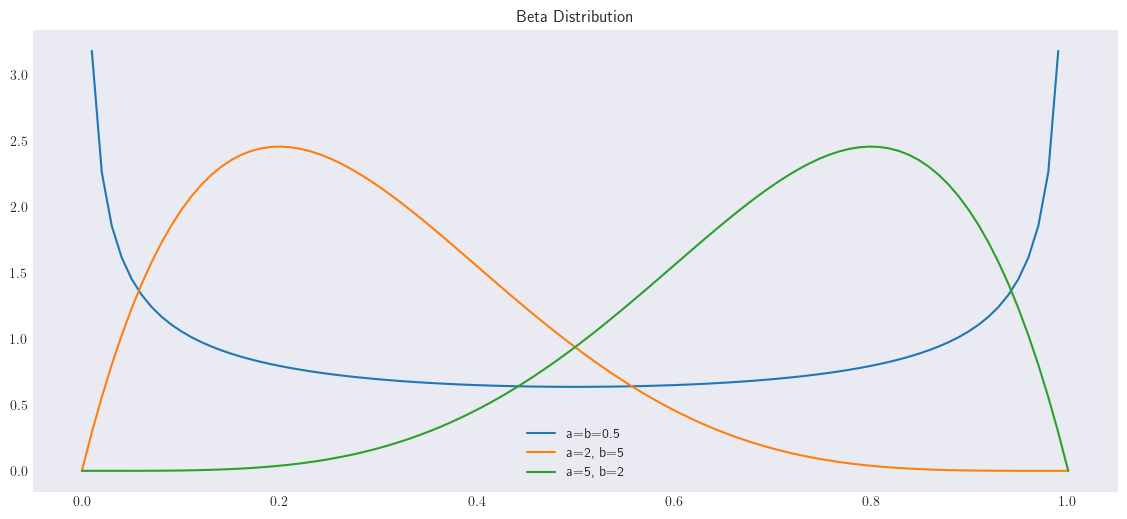

In [147]:
bt = BetaDistribution(None, None)
bt.import_data('MGD.csv')
bt.visualize_book(bt.data)